In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor 
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

%matplotlib inline

First, we have to decide how to deal with longitudinality. For now, we will ignore longitudinal data and treat each row as a unique patient. This means we need to take out any 'baseline' data.

In [2]:
df = pd.read_csv('ADNIMERGE.csv')
all_cols = list(df)
df.dtypes

# baseline data is indicated by '_bl' OR described as a baseline measurement in ADNIMERGE_DICT
important_cols = [i for i in all_cols[9:-3] if i[-2:] != 'bl']

In [3]:
important_cols = ['RID'] + important_cols

In [4]:
data = df[important_cols]

`AGE` is probably an important predictor for a diagnosis. However, ADNIMERGE_DICT says that `AGE` is the age of the patient at baseline. Because we are treating each row as a separate patient, we should use `Month_bl` (months from baseline) to calculate a 'new age' for each row. That is, a 65 year old who gets a second exam 12 months later will be treated as a different, 66 year old person.

In [5]:
data['EXACT_AGE'] = df.AGE + (df.Month_bl/12)

/Users/agasthyapradhan-shenoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [6]:
# now we need to one-hot encode the categorical predictors
# BUT since we will eventually do a classification with DX,
# we'll first convert those values and then one-hot encode
# things like marriage, etc

DX_class = []
for i in data.DX.values:
    if i == 'CN':
        DX_class.append(0)
    elif i == 'MCI':
        DX_class.append(1)
    elif i == 'Dementia':
        DX_class.append(2)
    else:
        DX_class.append(i) # for NaNs. will deal with missingness next.

# now drop the original DX column
data.drop('DX',axis=1,inplace=True)

# and replace with the new DX_class column
data['DX_class'] = DX_class

/Users/agasthyapradhan-shenoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/agasthyapradhan-shenoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
# get columns with categorical data
# by finding columns that have strings as entries
cat_cols = [i for i in data.columns if isinstance(data[i][0], str)]
cat_cols = cat_cols + ['DX_class']

In [8]:
# choosing to drop first because that was the 
# suggested best practice in HW3
data_hot = pd.get_dummies(data, columns = cat_cols, drop_first = True)

In [9]:
data_hot.shape

(13017, 55)

Now we need to deal with missingness.

In [10]:
# what percent of each column is missing?
def percent_in_each_col(df):
    percent_missing = [df[i].isnull().mean()*100 for i in list(df)]
    percent_missing = np.asarray(percent_missing)
    in_each = pd.DataFrame(percent_missing,df.columns,columns=["Percent"])
    print(in_each[in_each.Percent > 0])
    print("Average percent missing for all columns: ", in_each[in_each.Percent > 0].mean())


In [11]:
percent_in_each_col(data_hot)

                         Percent
APOE4                   0.453253
FDG                    74.241377
PIB                    98.286856
AV45                   83.398633
CDRSB                  30.736729
ADAS11                 31.174618
ADAS13                 31.835292
MMSE                   29.522932
RAVLT_immediate        30.383345
RAVLT_learning         30.383345
RAVLT_forgetting       30.583084
RAVLT_perc_forgetting  31.120842
FAQ                    29.000538
MOCA                   60.052239
EcogPtMem              59.360836
EcogPtLang             59.483752
EcogPtVisspat          59.798725
EcogPtPlan             59.560575
EcogPtOrgan            60.382577
EcogPtDivatt           59.798725
EcogPtTotal            59.453023
EcogSPMem              59.099639
EcogSPLang             59.061228
EcogSPVisspat          59.829454
EcogSPPlan             59.545210
EcogSPOrgan            60.866559
EcogSPDivatt           60.121380
EcogSPTotal            59.099639
Ventricles             42.790197
Hippocampu

Some of the features have more than 50% of the data missing. This is because some tests were not used during certain protocols (ADNI1 vs ADNIGO, for example). Not sure exactly how to deal with that. Right now, we're just going to impute values for all the missing data, and see where that gets us.

In [12]:
# In lecture, Kevin mentioned that imputing using the median
# will often give you the best results

from sklearn.preprocessing import Imputer

imp = Imputer(strategy="median")
imputed = imp.fit_transform(data_hot)
full_data = pd.DataFrame(imputed,columns = data_hot.columns)

percent_in_each_col(full_data)

Empty DataFrame
Columns: [Percent]
Index: []
Average percent missing for all columns:  Percent   NaN
dtype: float64


In [13]:
full_data.head()

,RID,PTEDUCAT,APOE4,FDG,PIB,AV45,CDRSB,ADAS11,ADAS13,MMSE,...,PTRACCAT_Unknown,PTRACCAT_White,PTMARRY_Married,PTMARRY_Never married,PTMARRY_Unknown,PTMARRY_Widowed,FLDSTRENG_3 Tesla MRI,FSVERSION_Cross-Sectional FreeSurfer (FreeSurfer Version 4.3),DX_class_1.0,DX_class_2.0
0,2.0,16.0,0.0,1.36926,1.85,1.11467,0.0,10.67,18.67,28.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,3.0,18.0,1.0,1.09079,1.85,1.11467,4.5,22.00,31.00,20.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,3.0,18.0,1.0,1.06360,1.85,1.11467,6.0,19.00,30.00,24.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,3.0,18.0,1.0,1.10384,1.85,1.11467,3.5,24.00,35.00,17.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,3.0,18.0,1.0,1.03871,1.85,1.11467,8.0,25.67,37.67,19.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


Now, we want to run a few different types of regressions on this 'full' data set using each cognitive test as a response variable. We'll create a matrix of R^2 values, and use that to decide which model should be used as our 'meta test'. **ALSO**: should we be standardizing the continuous variables??

In [14]:
def split_and_score(df, response_col_name, model):
    # returns TEST score based on model fitted to data with specified response var
    # response_col_name is a string
    # model is an unfitted sklearn model
    # would be nice to add a polynomial features option
    np.random.seed(9001)
    msk = np.random.rand(len(df)) < .75
    
    train = df[msk]
    test = df[~msk]
        
    predictors = [i for i in df.columns[1:] if i not in response_col_name]
    x = train[predictors]
    y = train[response_col_name]
    
    Xt = test[predictors]
    yt = test[response_col_name]        
    
    model.fit(x,y)
    test_score = model.score(Xt, yt)
    return test_score 

In [15]:
def make_score_df(df,response_vars,model_dict):
    # returns a dataframes of TEST r^2 values
    # response_vars is a list of strings
    # model_dict is a dictionary of unfitted sklearn models
    
    keys = list(model_dict.keys())
    scores = np.zeros((len(response_vars),len(keys)))
    
    for col, model in enumerate(keys):
        for row, response in enumerate(response_vars):
            scores[row,col] = split_and_score(df,response,model_dict[model])
   
    score_df = pd.DataFrame(scores,columns=[keys],index=response_vars)

    return score_df
    

In [16]:
cog_tests = ['ADAS11','ADAS13','CDRSB','MOCA','MMSE','RAVLT_perc_forgetting','FAQ']

models = {}
models['KNN'] = KNeighborsRegressor(n_neighbors = 25)
models['LinearRegression'] = LinearRegression(fit_intercept = True)
models['Ridge'] = RidgeCV()
models['Lasso'] = LassoCV()
models['RandomForest'] = RandomForestRegressor()
models['DecisionTree'] = DecisionTreeRegressor()

In [17]:
poop = make_score_df(full_data,cog_tests,models)

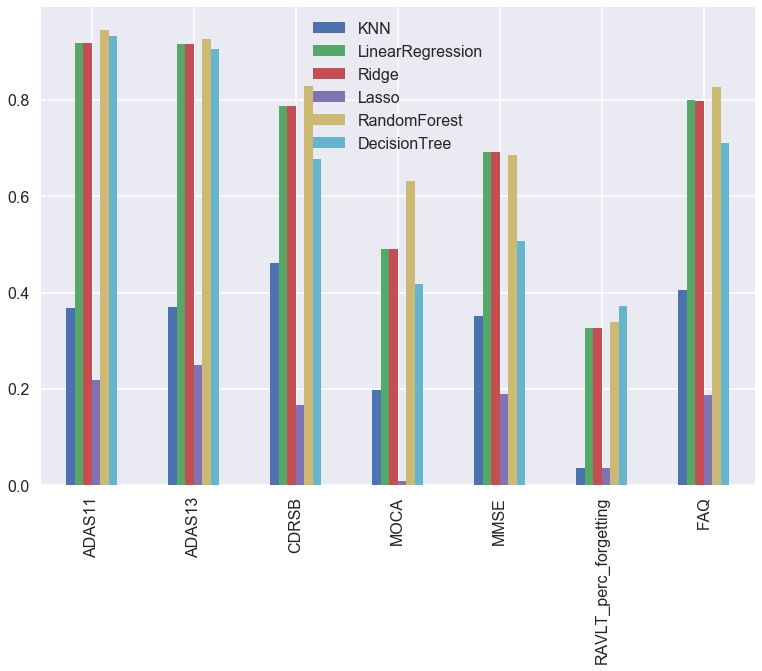

In [18]:
sns.set_context("poster")
poop.plot(kind="bar")

In [19]:
poop

,KNN,LinearRegression,Ridge,Lasso,RandomForest,DecisionTree
ADAS11,0.367276,0.918098,0.918198,0.219364,0.946174,0.932757
ADAS13,0.370538,0.916701,0.916718,0.249385,0.925571,0.904851
CDRSB,0.461846,0.787984,0.787524,0.165541,0.828050,0.677340
MOCA,0.197025,0.490371,0.490218,0.007704,0.632128,0.416676
MMSE,0.351739,0.690848,0.691302,0.190285,0.686176,0.506055
RAVLT_perc_forgetting,0.035112,0.326822,0.326445,0.036130,0.339026,0.372367
FAQ,0.405280,0.799050,0.798718,0.187249,0.827819,0.711406


assuming all the above is correct, it looks like the random forest model with ADAS11 as a predictor is the best. SO: add the predictions from that model as a feature. Do a multi class logistic regression or decision tree on just that feature with the original DX_class as the classes.

In [20]:
# create the new meta-test feature
# I *think* to do this, we'll need to test/train on a subset of the data
# then predict on the whole 'full_data' (????? this seems wrong as we would be 
# double using data but not sure how else to do this)

# create subset
np.random.seed(9001)
meta_msk = np.random.rand(len(full_data)) < .5
small = full_data[meta_msk]

# train test split
np.random.seed(9001)
msk = np.random.rand(len(small)) < .75
train = small[msk]
test = small[~msk]

predictors = [i for i in full_data.columns[1:] if i not in 'ADAS11']

x = train[predictors]
y = train['ADAS11']

Xt = test[predictors]
yt = test['ADAS11']

# the set to make final predictions on (all the data)
x_final = full_data[predictors]

rf = RandomForestRegressor()
rf.fit(x,y)

# column of predictions
meta = rf.predict(x_final)


In [21]:
# ok now, we want the full DX_class column back. 
# so, go back to 'data' and impute NaNs
# and add meta to that

In [22]:
# redo one-hot encoding, excluding DX_class column this time
cat_cols2 = [i for i in data.columns if isinstance(data[i][0], str)]
data = pd.get_dummies(data,columns=cat_cols2,drop_first=True)

# impute
imp = Imputer(strategy = 'median')
cols = data.columns
data = imp.fit_transform(data)

data = pd.DataFrame(data,columns=cols)

In [23]:
data['MetaTest'] = meta

In [24]:
# to find splits, we just want to look at these two columns (?? I think)
two = data[['MetaTest','DX_class']]

In [25]:
np.random.seed(9001)
msk = np.random.rand(len(two)) < .75
train2 = two[msk]
test2 = two[~msk]

# train vars
x_tr = train2['MetaTest'].values.reshape(-1,1)
y_tr = train2['DX_class']

# test vars
x_ts = test2['MetaTest'].values.reshape(-1,1)
y_ts = test2['DX_class']

from sklearn.linear_model import LogisticRegressionCV

logit = LogisticRegressionCV(multi_class='multinomial')

logit.fit(x_tr,y_tr)

logit.score(x_ts,y_ts)

0.77353215284249766

In [26]:
rfc = RandomForestClassifier()
rfc.fit(x_tr,y_tr)
rfc.score(x_ts,y_ts)

0.7312830071450761

In [27]:
poly = PolynomialFeatures(degree=2, include_bias = True)
x_tr_poly = poly.fit_transform(x_tr)
x_ts_poly = poly.fit_transform(x_ts)
log_poly = LogisticRegressionCV(multi_class='multinomial')
log_poly.fit(x_tr_poly,y_tr)
log_poly.score(x_ts_poly,y_ts)

0.77322149735942836

Looks like the logistic regression gives us the best results (Patrick hinted at this). Check class accuracies:

In [28]:
from sklearn import metrics
def conf_mat(model,x,y,name):
    # model must be fitted to training data before calling this function
    # x and y should be test
    yp = model.predict(x)
    m = metrics.confusion_matrix(y, yp)
    cn_acc = m[0,0]/np.sum(m[0])
    mci_acc = m[1,1]/np.sum(m[1])
    ad_acc = m[2,2]/np.sum(m[2])
    print(name)
    print("CN Class Accuracy: %f\nMCI Class Accuracy: %f\nAD Class Accuracy: %f\n"%(cn_acc,mci_acc,ad_acc))

In [29]:
conf_mat(logit,x_ts,y_ts,"Logistic Regression")

conf_mat(rfc,x_ts,y_ts,"Random Forest")

conf_mat(log_poly,x_ts_poly,y_ts,"Log w Quad Terms")

Logistic Regression
CN Class Accuracy: 0.487407
MCI Class Accuracy: 0.895129
AD Class Accuracy: 0.676692

Random Forest
CN Class Accuracy: 0.576296
MCI Class Accuracy: 0.800696
AD Class Accuracy: 0.665414

Log w Quad Terms
CN Class Accuracy: 0.546667
MCI Class Accuracy: 0.877237
AD Class Accuracy: 0.667293



In [30]:
# masks
ad = data[data.DX_class == 2]
mci = data[data.DX_class == 1]
cn = data[data.DX_class == 0]

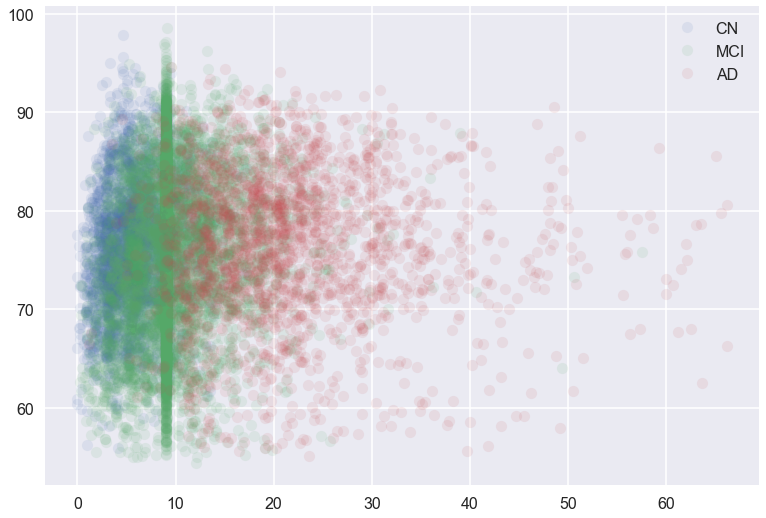

In [31]:
plt.plot(cn.MetaTest, cn.EXACT_AGE, "o", alpha=.1,label = "CN")
plt.plot(mci.MetaTest, mci.EXACT_AGE, "o", alpha=.1,label = "MCI")
plt.plot(ad.MetaTest, ad.EXACT_AGE, "o", alpha=.1, label = "AD")

plt.legend(loc="best")